In [1]:
import pandas as pd
import torch
import torch_geometric
from torch_geometric.data import Dataset, Data
import numpy as np 
from torch_geometric.loader import DataLoader
from torch_geometric.nn import Sequential, GCNConv,SAGEConv, GATConv
import matplotlib.pyplot as plt
from torch.nn import Linear
import torch.nn.functional as F
from sklearn.metrics import precision_score, recall_score, accuracy_score
import time
import MyData as data
from sklearn.model_selection import KFold
import GNN_model

In [2]:
sel_alg=0
view='xz'
# lr=0.0001

In [ ]:
if sel_alg==3:
    num_ly=3
    num_to_reduce=64
    sel_alg=3
    lr=5e-5
    view='xz'
    n_epochs=1500

In [5]:
%%time
data=data.dataset_preparation(root='/lustrehome/federicacuna/TB_Sept_2023_ml/Data/preprocessed/')
if view=='xz':
    fname='pi-_10GeV_4ly_1e-4_inclined_NEW_viewx'
    # fname='pi-_10GeV_4ly_1e-4_inclined_4ly_GAT_viewx'
else:
    fname='pi-_10GeV_4ly_1e-4_inclined_NEW_viewy'
    # fname='pi-_10GeV_4ly_1e-4_inclined_4ly_GAT_viewy'
data_trk=data.get_more_file(0,300,fname)
train_dataset = data_trk[:2000000]
val_dataset =data.get_more_file(300,400,fname)[:400000]
test_dataset =data.get(500,fname)
print('len_train_dataset ',len(train_dataset))
print('len_val_dataset ',len(val_dataset))
print('len_test_dataset ',len(test_dataset))

file 31 not found
file 81 not found
taking a list of file from  0  to  150
taking a list of file from  230  to  275
taking the  data_280.pt
len_train_dataset  1000000
len_val_dataset  400000
len_test_dataset  9315
CPU times: user 4min 59s, sys: 7.66 s, total: 5min 6s
Wall time: 5min 29s


In [10]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [6]:
%%time
NUM_FEATURES = train_dataset[0].x.shape[1]
print(NUM_FEATURES)
NUM_CLASSES =1
n_ly=3
model_list=['SageConv','SageConv2','GCN','GCN_2','GAT','GDPModel']

CPU times: user 8 µs, sys: 3 µs, total: 11 µs
Wall time: 21.7 µs


In [11]:
if sel_alg>len(model_list):
    print('no algorithm available')
if sel_alg==0:
    model = GNN_model.SageConv(num_feat=NUM_FEATURES,num_class=NUM_CLASSES)
    print(model)
elif sel_alg==1:
    model = GNN_model.SageConv2(num_feat=NUM_FEATURES,num_class=NUM_CLASSES)
elif sel_alg==2:
    model = GNN_model.GCN(num_feat=NUM_FEATURES, num_class=NUM_CLASSES)
elif sel_alg==3:
    model = GNN_model.GCN_2(hidden_size=hidden_size, num_ly=num_ly, num_feat=NUM_FEATURES, num_class=NUM_CLASSES,num_to_reduce=64)
elif sel_alg==4:
    model = GNN_model.GAT(num_feat=NUM_FEATURES, num_class=NUM_CLASSES)
elif sel_alg==5:
    model=GNN_model.GDPModel()

In [12]:
%%time
model.to(device)
print(model)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
####criterion = torch.nn.CrossEntropyLoss()
criterion=torch.nn.functional.binary_cross_entropy#for sageconv

def train_model(train_data):
    model.to(device)
    model.train()
    for data in train_data:
        data.to(device)
        out = model(data) # Perform a single forward pass.
        labels=data.y.float().to(device)
        loss = criterion(out.squeeze(1).float(), labels)  # Compute the loss.
        
        loss.backward()  # Derive gradients.
        optimizer.step()  # Update parameters based on gradients.
        optimizer.zero_grad()  # Clear gradients.
    return model.to(device)

threshold=0.8
def evaluate_model(model,test_data):
    model.eval()
    correct = 0
    total_samples = 0
    model_outputs = []
    targets = []
    pred_class=[]

    for data in test_data:
        data.to(device)
        model_output = model(data)
        model_output.to(device)
        predicted_class = torch.where(model_output > threshold, 1, 0)
        
        correct += int((predicted_class == data.y.float()).sum())
        total_samples += len(data.y)

          # store these to get the loss
        model_outputs.extend(model_output.tolist())
        targets.extend(data.y.float().tolist())
        pred_class.extend(predicted_class.tolist())

    
    loss = criterion(torch.tensor(model_outputs).squeeze(1), torch.tensor(targets).float())
    accuracy = accuracy_score(targets, pred_class)
    precision = precision_score(targets, pred_class)
    recall = recall_score(targets, pred_class)
    
    return accuracy, loss, recall, precision 

GDPModel(
  (convs1): GATConv(5, 128, heads=8)
  (convs2): GATConv(1024, 1, heads=1)
)
CPU times: user 22.2 ms, sys: 152 ms, total: 174 ms
Wall time: 195 ms


In [12]:
def reset_weights(m):
    if isinstance(m, SAGEConv) or isinstance(m,Linear):
        m.reset_parameters()

In [13]:
batch_size=4032
folds=5
epochs=500
kfold=KFold(n_splits=folds,shuffle=True)

In [16]:
train_accuracies = []
validation_accuracies = []
validation_losses = []
train_losses = []

val_recall=[]
val_precision=[]
train_recall=[]
train_precision=[]
times = []

trainacc_per_fold = [[] for _ in range(folds)]
trainloss_per_fold= [[] for _ in range(folds)]

valacc_per_fold = [[] for _ in range(folds)]
valloss_per_fold= [[] for _ in range(folds)]

trainrec_per_fold = [[] for _ in range(folds)]
valrec_per_fold = [[] for _ in range(folds)]

trainprec_per_fold = [[] for _ in range(folds)]
valprec_per_fold= [[] for _ in range(folds)]

for fold,(train_idx,val_idx) in enumerate(kfold.split(data_trk)):
    #print('------------fold no---------{}----------------------'.format(fold))
    #print('----', train_idx,'-----',val_idx)
    train_subsampler = torch.utils.data.SubsetRandomSampler(train_idx)
    val_subsampler = torch.utils.data.SubsetRandomSampler(val_idx)
   
    train_loader = DataLoader(
                      data_trk, 
                      batch_size=batch_size, sampler=train_subsampler,pin_memory=True,num_workers=15,drop_last=True)
    
    val_loader = DataLoader(
                      data_trk,
                      batch_size=batch_size, sampler=val_subsampler,pin_memory=True,num_workers=15,drop_last=True)
    reset_weights(model)
    #print('1 ', len(train_loader),' 2 ',len(val_loader))
    
    for epoch in range(1, epochs):
        start = time.time()
        model = train_model(train_loader)
        train_acc, train_loss, train_rec, train_prec = evaluate_model(model,train_loader)
        
        val_acc, val_loss, val_rec, val_prec = evaluate_model(model,val_loader)
       
        train_losses.append(train_loss)
        validation_losses.append(val_loss)

        train_accuracies.append(train_acc)
        validation_accuracies.append(val_acc)

        train_precision.append(train_prec)
        val_precision.append(val_prec)

        train_recall.append(train_rec)
        val_recall.append(val_rec)
        if epoch % 1== 0:
            print(f'Epoch: {epoch}, Train Acc: {train_acc:.4f}, Train Loss: {train_loss:.4f},time :{time.time() - start}')
        
        trainacc_per_fold[fold].append(train_acc)
        valacc_per_fold[fold].append(val_acc)
        
        trainloss_per_fold[fold].append(train_loss)
        valloss_per_fold[fold].append(val_loss)
        
        trainrec_per_fold[fold].append(train_rec)
        valrec_per_fold[fold].append(val_rec)
        
        trainprec_per_fold[fold].append(train_prec)
        valprec_per_fold[fold].append(val_prec)
        '''
        print(torch.cuda.get_device_name(0))
        print('Memory Usage:')
        print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
        print('Cached:   ', round(torch.cuda.memory_reserved(0)/1024**3,1), 'GB')
        '''
        

Epoch: 1, Train Acc: 0.9322, Train Loss: 0.1556,time :122.49996089935303
Epoch: 2, Train Acc: 0.9334, Train Loss: 0.1494,time :104.40346884727478
Epoch: 3, Train Acc: 0.9406, Train Loss: 0.1461,time :123.85228300094604
Epoch: 4, Train Acc: 0.9400, Train Loss: 0.1383,time :139.067946434021
Epoch: 5, Train Acc: 0.9473, Train Loss: 0.1369,time :123.45116829872131
Epoch: 6, Train Acc: 0.9335, Train Loss: 0.1373,time :150.02416062355042
Epoch: 7, Train Acc: 0.9435, Train Loss: 0.1292,time :149.32545161247253
Epoch: 8, Train Acc: 0.9495, Train Loss: 0.1306,time :119.42675304412842
Epoch: 9, Train Acc: 0.9458, Train Loss: 0.1252,time :131.11830019950867


Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x7f7c73e5c710>>
Traceback (most recent call last):
Exception in thread Thread-32 (_pin_memory_loop):
Traceback (most recent call last):
  File "/opt/miniconda3/lib/python3.11/threading.py", line 1038, in _bootstrap_inner
    self.run()
  File "/opt/miniconda3/lib/python3.11/site-packages/ipykernel/ipkernel.py", line 761, in run_closure
    _threading_Thread_run(self)
  File "/opt/miniconda3/lib/python3.11/threading.py", line 975, in run
    self._target(*self._args, **self._kwargs)
  File "/home/federicacuna/.local/lib/python3.11/site-packages/torch/utils/data/_utils/pin_memory.py", line 53, in _pin_memory_loop
    do_one_step()
  File "/home/federicacuna/.local/lib/python3.11/site-packages/torch/utils/data/_utils/pin_memory.py", line 30, in do_one_step
    r = in_queue.get(timeout=MP_STATUS_CHECK_INTERVAL)
        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^


KeyboardInterrupt: 

In [15]:
import pickle
#save data as dictionary
file_path = f'/lustrehome/federicacuna/TB_Sept_2023_ml/cross_validation_results/CV_results_{model_list[sel_alg]}.pkl'

# Salva i dati in un file utilizzando pickle
with open(file_path, 'wb') as file:
    pickle.dump({
        'trainloss_per_fold': trainloss_per_fold,
        'valloss_per_fold': valloss_per_fold,
        'trainrec_per_fold': trainrec_per_fold,
        'valrec_per_fold': valrec_per_fold,
        'trainprec_per_fold': trainprec_per_fold,
        'valprec_per_fold': valprec_per_fold,
        'trainacc_per_fold':trainacc_per_fold,
        'valacc_per_fold':valacc_per_fold,
    }, file)



In [18]:
symbol = "\u00B1"
print(f' train accuracy:{np.average(train_accuracies):.3f} {symbol} {np.std(train_accuracies):.3f}')
print(f' val accuracy:{np.average(validation_accuracies):.3f} {symbol} {np.std(validation_accuracies):.3f}')
print(f' train recall:{np.average(train_recall):.3f} {symbol} {np.std(train_recall):.3f}')
print(f' val recall:{np.average(val_recall):.3f} {symbol} {np.std(val_recall):.3f}')
print(f' train precision:{np.average(train_precision):.4f} {symbol} {np.std(train_precision):.4f}')
print(f' val precision:{np.average(val_precision):.4f} {symbol} {np.std(val_precision):.4f}')

 train accuracy:0.918 ± 0.006
 val accuracy:0.918 ± 0.005
 train recall:0.896 ± 0.010
 val recall:0.896 ± 0.009
 train precision:0.9806 ± 0.0019
 val precision:0.9808 ± 0.0035


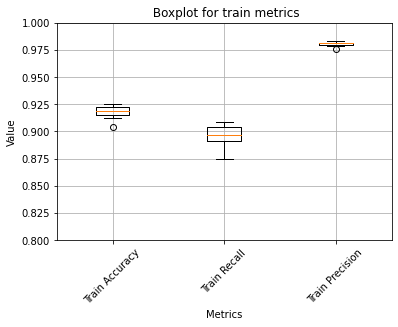

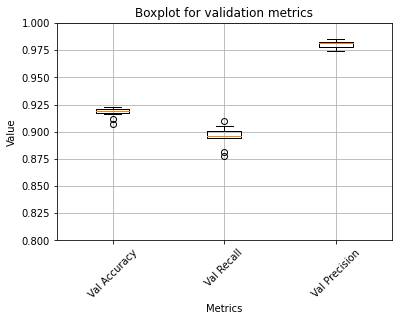

In [20]:
all_metrics_val = [
    [val for sublist in valacc_per_fold for val in sublist],
    [val for sublist in valrec_per_fold for val in sublist],
    [val for sublist in valprec_per_fold for val in sublist]
]

all_metrics_train = [
    [val for sublist in trainacc_per_fold for val in sublist],
    [val for sublist in trainrec_per_fold for val in sublist],
    [val for sublist in trainprec_per_fold for val in sublist],

]

# Labels per le diverse metriche
labels_train = [
    'Train Accuracy',
    'Train Recall',
    'Train Precision',
]
labels_val = [
    'Val Accuracy',
    'Val Recall',
    'Val Precision'
]

# Creazione del boxplot combinato
plt.figure()
plt.boxplot(all_metrics_train, labels=labels_train)
plt.xlabel('Metrics')
plt.ylabel('Value')
plt.title(' Boxplot for train metrics')
plt.xticks(rotation=45)
plt.ylim(0.8,1)
plt.grid(True)
plt.savefig(f'/lustrehome/federicacuna/TB_Sept_2023_ml/cross_validation_results/box_plot_train__{model_list[sel_alg]}.png',bbox_inches='tight')
plt.show()


# Creazione del boxplot combinato
plt.figure()
plt.boxplot(all_metrics_val, labels=labels_val)
plt.xlabel('Metrics')
plt.ylabel('Value')
plt.title('Boxplot for validation metrics')
plt.xticks(rotation=45)
plt.grid(True)
plt.ylim(0.8,1)
plt.savefig(f'/lustrehome/federicacuna/TB_Sept_2023_ml/cross_validation_results/box_plot_val__{model_list[sel_alg]}.png',bbox_inches='tight')
#plt.show()